In [4]:
import numpy as np
import stim

# function to get the i'th bit of an integer n
def get_bit(n, i):
    return (n >> i) & 1

In [15]:
QRM_X_CHECKS = [
    [1,3,5,7,9,11,13,15],
    [2,3,6,7,10,11,14,15],
    [4,5,6,7,12,13,14,15],
    [8,9,10,11,12,13,14,15]
]

QRM_Z_CHECKS = [
    [ 1, 3, 5, 7, 0, 0],
    [ 3, 2, 7, 6, 0, 0],
    [ 2, 6,14,10, 0, 0],
    [ 6,14,12, 4, 0, 0],
    [13,12, 4, 5, 0, 0],
    [12, 8, 0,13, 9, 0],
    [ 8, 9,10,11, 0, 0],
    [ 9, 1,11, 3, 0, 0],
    [ 5, 7,13,15, 0, 0],
    [10,11,15,14, 0, 0],
    # redundancies
    [ 4, 5, 0, 0, 7, 6],
    [14, 0, 8, 0,10,12],
    [ 0, 0, 9, 1, 5,13],
    [ 0,10, 2, 0,11, 3],
    [ 0,15, 6, 0,14, 7],
    [15,13, 0, 0,12,14],
    [ 7, 0, 3, 0,15,11],
    [11, 0, 0, 9,13,15]
]

QRM_META_CHECKS = [
    [ 1,18, 8, 9],
    [ 1,18,13,17],
    [ 2,10,14,15],
    [ 2,10, 3,17],
    [ 5,15, 4, 9],
    [ 5,15,11,16],
    [ 7,16, 6,10],
    [ 7,16,12,18],
]

for sublist in QRM_Z_CHECKS:
    binary_sublist = [bin(x)[2:].zfill(4) for x in sublist]
    print(binary_sublist)

['0001', '0011', '0101', '0111', '0000', '0000']
['0011', '0010', '0111', '0110', '0000', '0000']
['0010', '0110', '1110', '1010', '0000', '0000']
['0110', '1110', '1100', '0100', '0000', '0000']
['1101', '1100', '0100', '0101', '0000', '0000']
['1100', '1000', '0000', '1101', '1001', '0000']
['1000', '1001', '1010', '1011', '0000', '0000']
['1001', '0001', '1011', '0011', '0000', '0000']
['0101', '0111', '1101', '1111', '0000', '0000']
['1010', '1011', '1111', '1110', '0000', '0000']
['0100', '0101', '0000', '0000', '0111', '0110']
['1110', '0000', '1000', '0000', '1010', '1100']
['0000', '0000', '1001', '0001', '0101', '1101']
['0000', '1010', '0010', '0000', '1011', '0011']
['0000', '1111', '0110', '0000', '1110', '0111']
['1111', '1101', '0000', '0000', '1100', '1110']
['0111', '0000', '0011', '0000', '1111', '1011']
['1011', '0000', '0000', '1001', '1101', '1111']


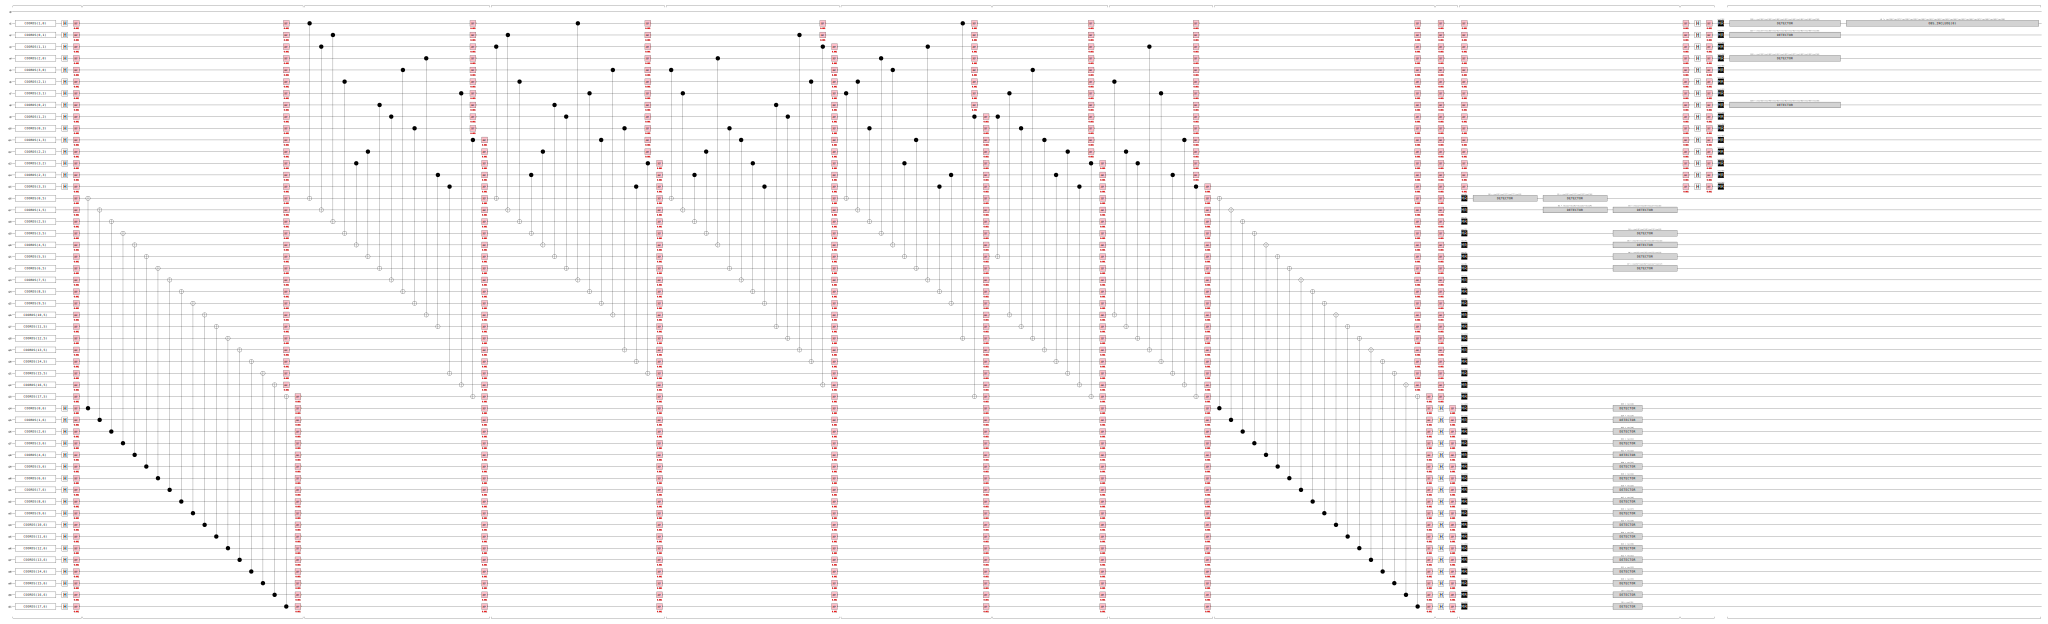

In [31]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,34):
        circuit.append("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        if i == 0:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
        for j in range(18):
            qubit = QRM_Z_CHECKS[j][i]
            if qubit != 0:
                circuit.append('CNOT', [qubit, 16 + j])
        circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
        circuit.append('TICK')
        if i == 5:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])


    # metachecks
    for mc in QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # final measurements
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')

[-6.457775907873672, -6.059260945398487, -5.4124531671153475, -4.781324804480712, -4.321818704082481, -3.8375096761423593, -3.361572351709554, -2.829025197269877, -2.300083306593107, -1.812636703778707] [0.8607899, 0.802341, 0.7237877, 0.6225325, 0.4993392, 0.3611345, 0.2250894, 0.11299, 0.0416092, 0.0098867]


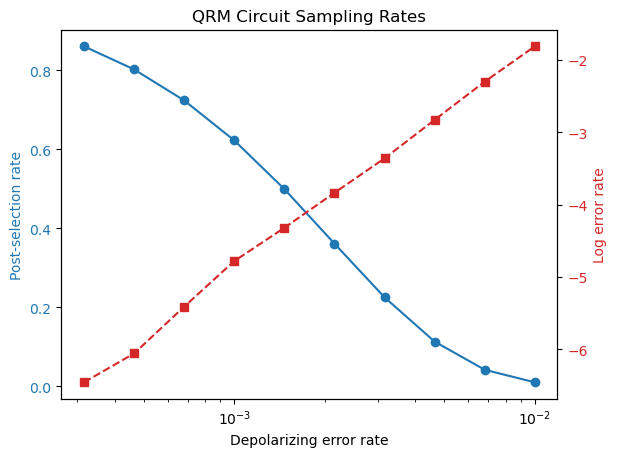

In [30]:
import matplotlib.pyplot as plt

def qrm_sampling(error_rate=0.01, N=200000):
    """
    Samples the QRM circuit with depolarizing noise.
    The error rate can be adjusted.
    Returns the post-selection rate and the error rate.
    """
    circuit = qrm_circuit_flag(error_rate)
    
    sampler = circuit.compile_sampler()
    converter = circuit.compile_m2d_converter()
    detector_samples = converter.convert(measurements=sampler.sample(N), append_observables=True)
    
    N_true = (detector_samples.sum(axis=1) == 0).sum()
    N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
    
    post_selection_rate = N_post / N
    log_error_rate = np.log10(1 - N_true / N_post)
    
    return post_selection_rate, log_error_rate

error_rates = [10**(x) for x in np.linspace(-3.5, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    post_selection_rate, log_error_rate = qrm_sampling(error_rate, N=int(1e7))
    post_selection_rates.append(post_selection_rate)
    log_error_rates.append(log_error_rate)

print(log_error_rates, post_selection_rates)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('QRM Circuit Sampling Rates')
plt.show()